In [2]:
import gym
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import SGDRegressor
import plotting
import itertools
import sys

import IPython.core.debugger
dbg = IPython.core.debugger.Pdb()

In [3]:
env = gym.envs.make("MountainCar-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [4]:
import sklearn.pipeline
import sklearn.preprocessing

from sklearn.kernel_approximation import RBFSampler
from sklearn.kernel_approximation import Nystroem

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", Nystroem(gamma=1.0, n_components=100)),
        ("rbf4", Nystroem(gamma=0.5, n_components=100))
        ])

featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', Nystroem(coef0=None, degree=None, gamma=1.0, kernel='rbf', kernel_params=None,
     n_components=100, random_state=None)), ('rbf4', Nystroem(coef0=None, degree=None, gamma=0.5, kernel='rbf', kernel_params=None,
     n_components=100, random_state=None))],
       transformer_weights=None)

In [5]:


# Testing featurizing a state
feature = env.observation_space.sample()

#print(feature)
#print(featurizer.transform(scaler.transform([feature])))

In [6]:
class Estimator:
    
    """
    Model for each action in the environment space
    """
    def __init__(self):
        self.models = []
    
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate = "constant")
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
     
    def featurize_state(self, state):
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        features = self.featurize_state(s)
        if not a:
            return np.array([m.predict([features])[0] for m in self.models])
        else:
            return self.models[a].predict([features])[0]
    
    def update(self, s, a, y):
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])

In [7]:
# policy function uses the estimator to determine the best policy

def make_epsilon_greedy_policy(estimator, epsilon, nA):
    
    def policy_fn(observation):   
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    
    return policy_fn

In [9]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
        
        stats = plotting.EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes)
        )
        
        for episode_i in range(num_episodes):
            policy = make_epsilon_greedy_policy(estimator, 
                                                epsilon * epsilon_decay*episode_i, 
                                                env.action_space.n)   
            
            
            last_reward = stats.episode_rewards[episode_i - 1]
            sys.stdout.flush()

            
            state = env.reset()
            next_action = None
            
            #print("Episode:", episode_i)
            
            for t in itertools.count():
                
                if next_action is None:
                    action_probs = policy(state)
                    
                    dbg.set_trace()
                    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
                else:
                    action = next_action
                 
                next_state, reward, done, _ = env.step(action)
                
                dbg.set_trace()
                stats.episode_rewards[episode_i] += reward
                stats.episode_lengths[episode_i] = t
                
                q_values_next = estimator.predict(next_state)
                dbg.set_trace()
                td_target = reward + discount_factor * np.max(q_values_next)
                
                estimator.update(state, action, td_target)
            
                if episode_i % 10 == 0:
                    print("\rStep {} @ Episode {}/{} ({})".format(t, episode_i + 1, num_episodes, last_reward), end="")
                
                if done:
                    break
                
                state = next_state
            #dbg.set_trace()
    
        return stats

In [10]:
estimator = Estimator()
stats = q_learning(env, estimator, 300, epsilon=0.0)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


> <ipython-input-9-4efc01051e20>(29)q_learning()
     27 
     28                     dbg.set_trace()
---> 29                     action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
     30                 else:
     31                     action = next_action

ipdb> action_probs
array([1., 0., 0.])
ipdb> q


BdbQuit: 

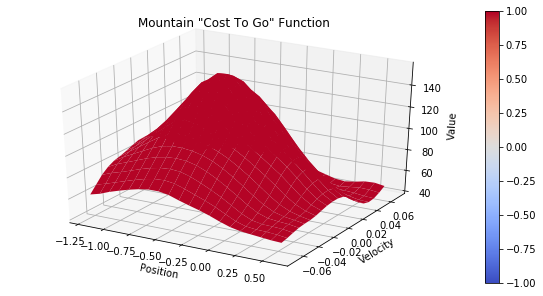

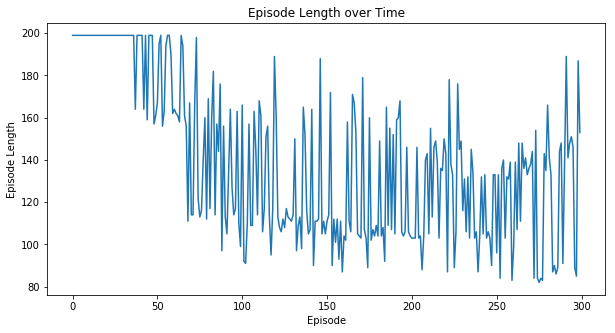

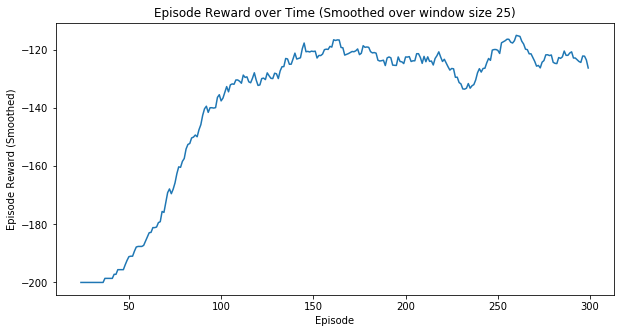

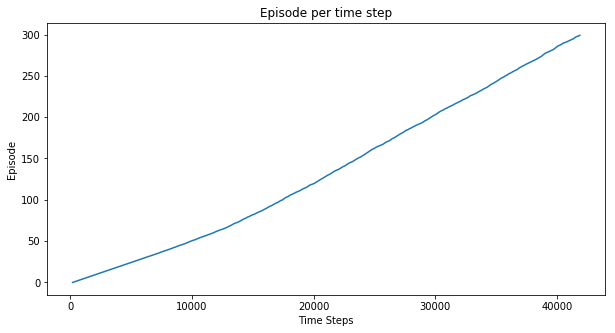

(<matplotlib.figure.Figure at 0x7fc9406cf080>,
 <matplotlib.figure.Figure at 0x7fc93e5163c8>)

In [9]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)